In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_csv('/kaggle/input/englishemotions/English_Dataset.csv')
df = df[df['text'] != 'label']
df = df.dropna(subset=['text', 'label'])

# Split dataset
df_train, df_temp = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
df_test, df_val = train_test_split(df_temp, test_size=0.5, random_state=42, stratify=df_temp['label'])

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(df_train['label'])
y_test = le.transform(df_test['label'])

In [2]:

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(df_train['text'])
X_test = vectorizer.transform(df_test['text'])

# Model evaluation function
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    results = {
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1 Score": f1_score(y_test, y_pred, average='weighted'),
        "ROC-AUC": roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')
    }
    return results

In [3]:
# Train and evaluate ML models
results = []

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
results.append(evaluate_model(lr, X_test, y_test, "Logistic Regression"))

svm = SVC(probability=True)
svm.fit(X_train, y_train)
results.append(evaluate_model(svm, X_test, y_test, "SVM"))

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)
results.append(evaluate_model(xgb_model, X_test, y_test, "XGBoost"))

lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)
results.append(evaluate_model(lgb_model, X_test, y_test, "LightGBM"))

# Display result table
results_df = pd.DataFrame(results)
print(results_df)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.062030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 388466
[LightGBM] [Info] Number of data points in the train set: 58130, number of used features: 6791
[LightGBM] [Info] Start training from score -2.528614
[LightGBM] [Info] Start training from score -2.374618
[LightGBM] [Info] Start training from score -3.790367
[LightGBM] [Info] Start training from score -3.289338
[LightGBM] [Info] Start training from score -3.421881
[LightGBM] [Info] Start training from score -2.768503
[LightGBM] [Info] Start training from score -1.492209
[LightGBM] [Info] Start training from score -1.551783
[LightGBM] [Info] Start training from score -1.920500
[LightGBM] [Info] Start training from score -3.336100
[LightGBM] [Info] Start training from score -3.264274
[LightGBM] [Info] Start training from score -4.211182
                 Model  Accuracy  Precision    Recall  F1 S

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, roc_auc_score

# Parameters
max_vocab = 20000
max_len = 200
embedding_dim = 100

# Tokenize text for DL models
tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['text'])

X_train_seq = tokenizer.texts_to_sequences(df_train['text'])
X_test_seq = tokenizer.texts_to_sequences(df_test['text'])

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Convert labels to one-hot
y_train_dl = tf.keras.utils.to_categorical(y_train)
y_test_dl = tf.keras.utils.to_categorical(y_test)
num_classes = y_train_dl.shape[1]

def compile_and_evaluate(model, name):
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train_pad, y_train_dl, epochs=3, batch_size=64, validation_split=0.1, verbose=0)
    y_pred = model.predict(X_test_pad)
    y_pred_labels = y_pred.argmax(axis=1)

    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred_labels),
        "Precision": precision_score(y_test, y_pred_labels, average='weighted', zero_division=0),
        "Recall": recall_score(y_test, y_pred_labels, average='weighted'),
        "F1 Score": f1_score(y_test, y_pred_labels, average='weighted'),
        "ROC-AUC": roc_auc_score(y_test_dl, y_pred, multi_class='ovr')
    }

2025-07-12 04:22:36.381394: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752294156.649515      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752294156.718424      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# CNN
cnn = Sequential([
    Embedding(max_vocab, embedding_dim, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(pool_size=2),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
results.append(compile_and_evaluate(cnn, "CNN"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1752294174.753719      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752294174.754369      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1752294177.037626     116 service.cc:148] XLA service 0x7ad960002c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752294177.038289     116 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752294177.038309     116 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capabili

228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [6]:
# LSTM
lstm = Sequential([
    Embedding(max_vocab, embedding_dim, input_length=max_len),
    LSTM(128),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
results.append(compile_and_evaluate(lstm, "LSTM"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [7]:
# CNN-LSTM
cnn_lstm = Sequential([
    Embedding(max_vocab, embedding_dim, input_length=max_len),
    Conv1D(64, 5, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(64),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
results.append(compile_and_evaluate(cnn_lstm, "CNN-LSTM"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [8]:
!pip install -q transformers

from transformers import BertTokenizer, TFBertForSequenceClassification, InputExample, create_optimizer
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Load BERT tokenizer and model
bert_model_name = 'bert-base-uncased'
tokenizer_bert = BertTokenizer.from_pretrained(bert_model_name)
model_bert = TFBertForSequenceClassification.from_pretrained(bert_model_name, num_labels=num_classes)

# Convert to InputExamples
def to_bert_examples(texts, labels):
    return [InputExample(guid=None, text_a=text, text_b=None, label=label) for text, label in zip(texts, labels)]

train_examples = to_bert_examples(df_train['text'], y_train)
test_examples = to_bert_examples(df_test['text'], y_test)

# Convert to TensorFlow Dataset
def convert_to_dataset(examples):
    encodings = tokenizer_bert(
        [e.text_a for e in examples],
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors='tf'
    )
    labels = tf.convert_to_tensor([e.label for e in examples])
    return tf.data.Dataset.from_tensor_slices((dict(encodings), labels)).batch(32)

train_dataset = convert_to_dataset(train_examples)
test_dataset = convert_to_dataset(test_examples)

# Create optimizer using HuggingFace's `create_optimizer`
steps_per_epoch = len(train_dataset)
optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=steps_per_epoch * 2  # 2 epochs
)

# Compile the BERT model
model_bert.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the BERT model
model_bert.fit(train_dataset, epochs=2, verbose=1)

# Evaluate the model
preds = model_bert.predict(test_dataset).logits
y_pred_bert = np.argmax(preds, axis=1)

# Append BERT results
results.append({
    "Model": "BERT",
    "Accuracy": accuracy_score(y_test, y_pred_bert),
    "Precision": precision_score(y_test, y_pred_bert, average='weighted', zero_division=0),
    "Recall": recall_score(y_test, y_pred_bert, average='weighted'),
    "F1 Score": f1_score(y_test, y_pred_bert, average='weighted'),
    "ROC-AUC": roc_auc_score(y_test_dl, tf.nn.softmax(preds).numpy(), multi_class='ovr')
})

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
1817/1817 [==============================] - 1719s 919ms/step - loss: 0.6554 - accuracy: 0.7675
Epoch 2/2
228/228 [==============================] - 78s 328ms/step


In [9]:
# Show results
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="F1 Score", ascending=False))

                 Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC
7                 BERT  0.858244   0.858712  0.858244  0.858345  0.990220
3             LightGBM  0.805395   0.804277  0.805395  0.803726  0.982662
1                  SVM  0.796587   0.798287  0.796587  0.793168  0.980401
2              XGBoost  0.792733   0.792329  0.792733  0.790569  0.978155
4                  CNN  0.791770   0.792270  0.791770  0.787810  0.978116
0  Logistic Regression  0.789430   0.790023  0.789430  0.785547  0.977268
5                 LSTM  0.643545   0.590361  0.643545  0.604220  0.941635
6             CNN-LSTM  0.542114   0.519585  0.542114  0.477470  0.924018


In [10]:
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification

# Load RoBERTa tokenizer and model
roberta_model_name = 'roberta-base'
roberta_tokenizer = RobertaTokenizer.from_pretrained(roberta_model_name)
roberta_model = TFRobertaForSequenceClassification.from_pretrained(roberta_model_name, num_labels=num_classes)

# Encode and convert to dataset
def convert_roberta_dataset(texts, labels):
    encodings = roberta_tokenizer(
        list(texts),
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors='tf'
    )
    dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), labels))
    return dataset.batch(32)

train_roberta_dataset = convert_roberta_dataset(df_train['text'], y_train)
test_roberta_dataset = convert_roberta_dataset(df_test['text'], y_test)

# Optimizer
from transformers import create_optimizer

steps_per_epoch = len(train_roberta_dataset)
optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5,
    num_train_steps=steps_per_epoch * 3,
    num_warmup_steps=0
)

# Compile and train
roberta_model.compile(optimizer=optimizer,
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

roberta_model.fit(train_roberta_dataset, epochs=3, verbose=1)

# Predict
roberta_preds = roberta_model.predict(test_roberta_dataset).logits
y_pred_roberta = np.argmax(roberta_preds, axis=1)

# Evaluation
results.append({
    "Model": "RoBERTa",
    "Accuracy": accuracy_score(y_test, y_pred_roberta),
    "Precision": precision_score(y_test, y_pred_roberta, average='weighted', zero_division=0),
    "Recall": recall_score(y_test, y_pred_roberta, average='weighted'),
    "F1 Score": f1_score(y_test, y_pred_roberta, average='weighted'),
    "ROC-AUC": roc_auc_score(y_test_dl, tf.nn.softmax(roberta_preds).numpy(), multi_class='ovr')
})

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/3
1817/1817 [==============================] - 1723s 923ms/step - loss: 0.6274 - accuracy: 0.7731
Epoch 2/3
1817/1817 [==============================] - 1684s 927ms/step - loss: 0.3364 - accuracy: 0.8640
Epoch 3/3
228/228 [==============================] - 74s 310ms/step


In [11]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

# Load DistilBERT
distilbert_model_name = 'distilbert-base-uncased'
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(distilbert_model_name)
distilbert_model = TFDistilBertForSequenceClassification.from_pretrained(distilbert_model_name, num_labels=num_classes)

# Tokenize
def convert_distilbert_dataset(texts, labels):
    encodings = distilbert_tokenizer(
        list(texts),
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors='tf'
    )
    dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), labels))
    return dataset.batch(32)

train_distil_dataset = convert_distilbert_dataset(df_train['text'], y_train)
test_distil_dataset = convert_distilbert_dataset(df_test['text'], y_test)

# Optimizer
steps_per_epoch = len(train_distil_dataset)
optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5,
    num_train_steps=steps_per_epoch * 3,
    num_warmup_steps=0
)

# Compile and train
distilbert_model.compile(optimizer=optimizer,
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=['accuracy'])

distilbert_model.fit(train_distil_dataset, epochs=3, verbose=1)

# Predict
distil_preds = distilbert_model.predict(test_distil_dataset).logits
y_pred_distil = np.argmax(distil_preds, axis=1)

# Evaluate
results.append({
    "Model": "DistilBERT",
    "Accuracy": accuracy_score(y_test, y_pred_distil),
    "Precision": precision_score(y_test, y_pred_distil, average='weighted', zero_division=0),
    "Recall": recall_score(y_test, y_pred_distil, average='weighted'),
    "F1 Score": f1_score(y_test, y_pred_distil, average='weighted'),
    "ROC-AUC": roc_auc_score(y_test_dl, tf.nn.softmax(distil_preds).numpy(), multi_class='ovr')
})

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
1817/1817 [==============================] - 853s 456ms/step - loss: 0.7008 - accuracy: 0.7480
Epoch 2/3
1817/1817 [==============================] - 829s 456ms/step - loss: 0.3684 - accuracy: 0.8523
Epoch 3/3
228/228 [==============================] - 39s 162ms/step


In [12]:
# Final evaluation table
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='F1 Score', ascending=False)
print(results_df)

                 Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC
8              RoBERTa  0.870355   0.871771  0.870355  0.870768  0.992343
7                 BERT  0.858244   0.858712  0.858244  0.858345  0.990220
9           DistilBERT  0.850537   0.850704  0.850537  0.850377  0.989721
3             LightGBM  0.805395   0.804277  0.805395  0.803726  0.982662
1                  SVM  0.796587   0.798287  0.796587  0.793168  0.980401
2              XGBoost  0.792733   0.792329  0.792733  0.790569  0.978155
4                  CNN  0.791770   0.792270  0.791770  0.787810  0.978116
0  Logistic Regression  0.789430   0.790023  0.789430  0.785547  0.977268
5                 LSTM  0.643545   0.590361  0.643545  0.604220  0.941635
6             CNN-LSTM  0.542114   0.519585  0.542114  0.477470  0.924018


In [13]:
# Load DeBERTa

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, create_optimizer

# DeBERTa model and tokenizer
model_name_deberta = "microsoft/deberta-base"
deberta_tokenizer = AutoTokenizer.from_pretrained(model_name_deberta)
deberta_model = TFAutoModelForSequenceClassification.from_pretrained(model_name_deberta, num_labels=num_classes)

# Tokenize and prepare datasets
def convert_deberta_dataset(texts, labels):
    encodings = deberta_tokenizer(list(texts), truncation=True, padding=True, max_length=128, return_tensors='tf')
    return tf.data.Dataset.from_tensor_slices((dict(encodings), labels)).batch(32)

train_deberta_dataset = convert_deberta_dataset(df_train['text'], y_train)
test_deberta_dataset = convert_deberta_dataset(df_test['text'], y_test)

# Optimizer for DeBERTa
steps = len(train_deberta_dataset)
deberta_optimizer, _ = create_optimizer(init_lr=2e-5, num_train_steps=steps * 3, num_warmup_steps=0)

# Compile and train DeBERTa
deberta_model.compile(optimizer=deberta_optimizer,
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
deberta_model.fit(train_deberta_dataset, epochs=3, verbose=1)

# Evaluate DeBERTa
deberta_preds = deberta_model.predict(test_deberta_dataset).logits
y_pred_deberta = np.argmax(deberta_preds, axis=1)

results.append({
    "Model": "DeBERTa",
    "Accuracy": accuracy_score(y_test, y_pred_deberta),
    "Precision": precision_score(y_test, y_pred_deberta, average='weighted', zero_division=0),
    "Recall": recall_score(y_test, y_pred_deberta, average='weighted'),
    "F1 Score": f1_score(y_test, y_pred_deberta, average='weighted'),
    "ROC-AUC": roc_auc_score(y_test_dl, tf.nn.softmax(deberta_preds).numpy(), multi_class='ovr')
})

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tf_model.h5:   0%|          | 0.00/555M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDebertaForSequenceClassification.

Some layers of TFDebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['cls_dropout', 'pooler', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
1817/1817 [==============================] - 2234s 1s/step - loss: 0.5983 - accuracy: 0.7761
Epoch 2/3
1817/1817 [==============================] - 2138s 1s/step - loss: 0.3064 - accuracy: 0.8742
Epoch 3/3
228/228 [==============================] - 94s 368ms/step


In [14]:
# Load RoBERTa-Large

from transformers import RobertaTokenizer, TFRobertaForSequenceClassification

# RoBERTa-large tokenizer and model
model_name_large = "roberta-large"
roberta_large_tokenizer = RobertaTokenizer.from_pretrained(model_name_large)
roberta_large_model = TFRobertaForSequenceClassification.from_pretrained(model_name_large, num_labels=num_classes)

# Convert text to TensorFlow Dataset (reduced max_length and batch_size)
def convert_roberta_large_dataset(texts, labels):
    encodings = roberta_large_tokenizer(
        list(texts),
        truncation=True,
        padding=True,
        max_length=128,  # Reduce from 256
        return_tensors='tf'
    )
    return tf.data.Dataset.from_tensor_slices((dict(encodings), labels)).batch(4)  # Reduce batch size

# Prepare datasets
train_roberta_large_dataset = convert_roberta_large_dataset(df_train['text'], y_train)
test_roberta_large_dataset = convert_roberta_large_dataset(df_test['text'], y_test)

# Create optimizer
steps = len(train_roberta_large_dataset)
roberta_large_optimizer, _ = create_optimizer(
    init_lr=1e-5,
    num_train_steps=steps * 3,  # 3 epochs
    num_warmup_steps=0
)

# Compile model
roberta_large_model.compile(
    optimizer=roberta_large_optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train model (use try-except to avoid crash on OOM)
try:
    roberta_large_model.fit(train_roberta_large_dataset, epochs=2, verbose=1)
except tf.errors.ResourceExhaustedError:
    print("⚠️ GPU ran out of memory. Try reducing batch size or sequence length further.")

# Evaluate model
roberta_large_preds = roberta_large_model.predict(test_roberta_large_dataset).logits
y_pred_roberta_large = np.argmax(roberta_large_preds, axis=1)

# Append evaluation results
results.append({
    "Model": "RoBERTa-Large",
    "Accuracy": accuracy_score(y_test, y_pred_roberta_large),
    "Precision": precision_score(y_test, y_pred_roberta_large, average='weighted', zero_division=0),
    "Recall": recall_score(y_test, y_pred_roberta_large, average='weighted'),
    "F1 Score": f1_score(y_test, y_pred_roberta_large, average='weighted'),
    "ROC-AUC": roc_auc_score(y_test_dl, tf.nn.softmax(roberta_large_preds).numpy(), multi_class='ovr')
})

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/2
14533/14533 [==============================] - 6290s 426ms/step - loss: 0.5786 - accuracy: 0.7857
Epoch 2/2
1817/1817 [==============================] - 251s 133ms/step


In [15]:
# Final Results Table

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='F1 Score', ascending=False)
print(results_df)

                  Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC
10              DeBERTa  0.873658   0.874751  0.873658  0.874017  0.992871
11        RoBERTa-Large  0.871043   0.873758  0.871043  0.871954  0.992759
8               RoBERTa  0.870355   0.871771  0.870355  0.870768  0.992343
7                  BERT  0.858244   0.858712  0.858244  0.858345  0.990220
9            DistilBERT  0.850537   0.850704  0.850537  0.850377  0.989721
3              LightGBM  0.805395   0.804277  0.805395  0.803726  0.982662
1                   SVM  0.796587   0.798287  0.796587  0.793168  0.980401
2               XGBoost  0.792733   0.792329  0.792733  0.790569  0.978155
4                   CNN  0.791770   0.792270  0.791770  0.787810  0.978116
0   Logistic Regression  0.789430   0.790023  0.789430  0.785547  0.977268
5                  LSTM  0.643545   0.590361  0.643545  0.604220  0.941635
6              CNN-LSTM  0.542114   0.519585  0.542114  0.477470  0.924018


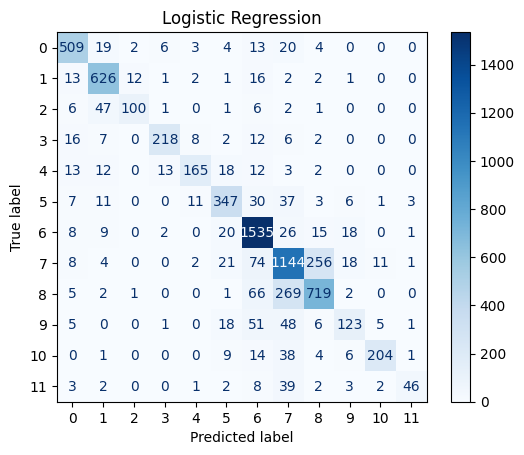

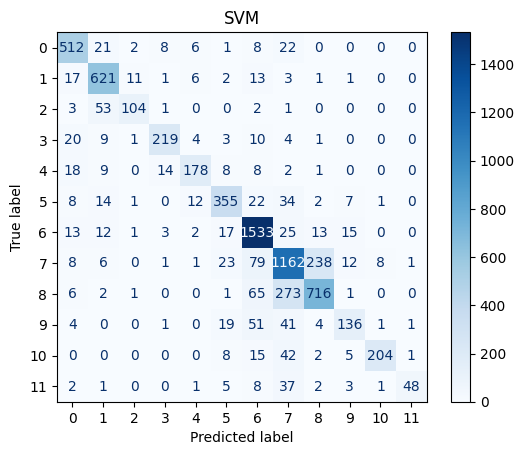

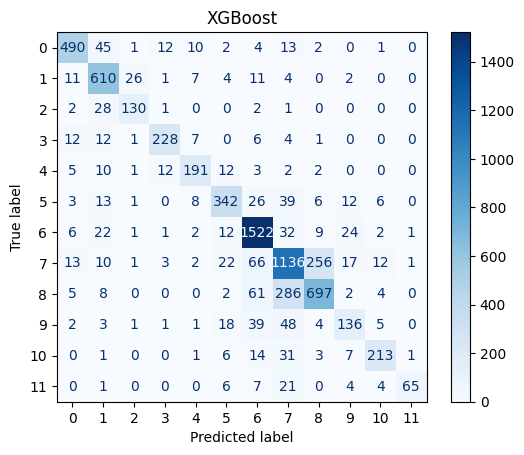

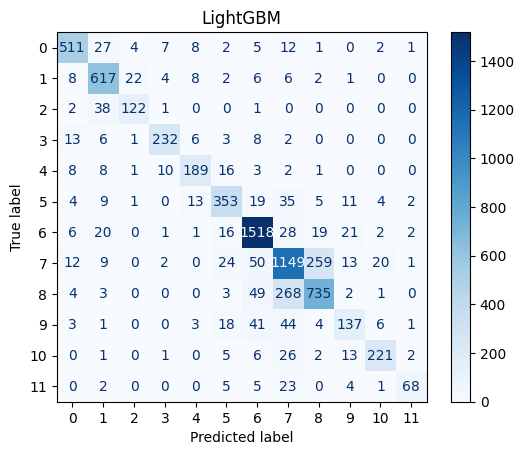

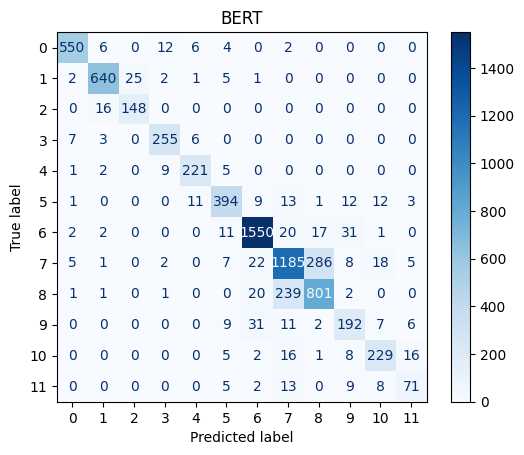

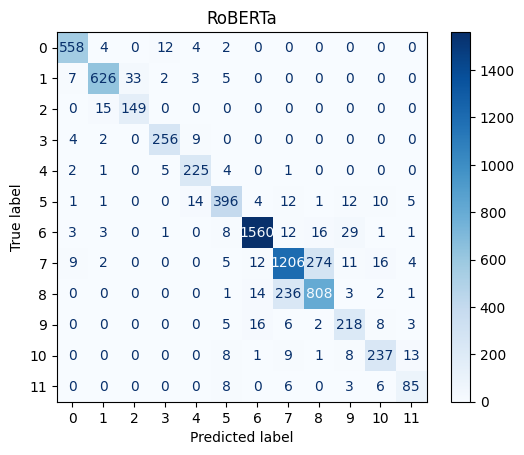

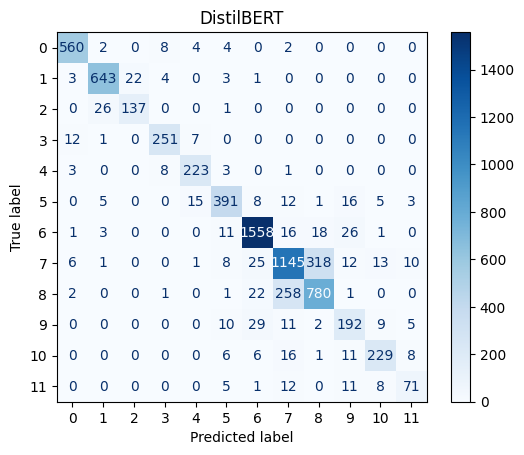

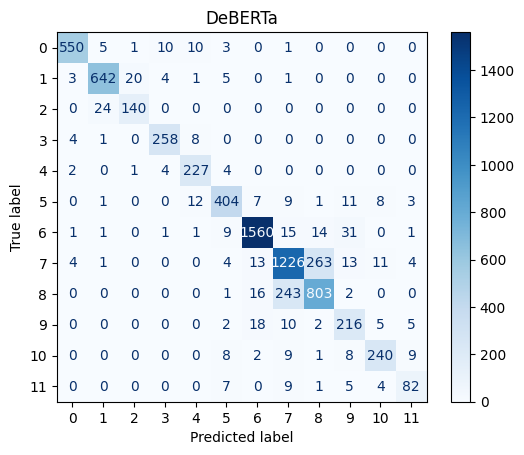

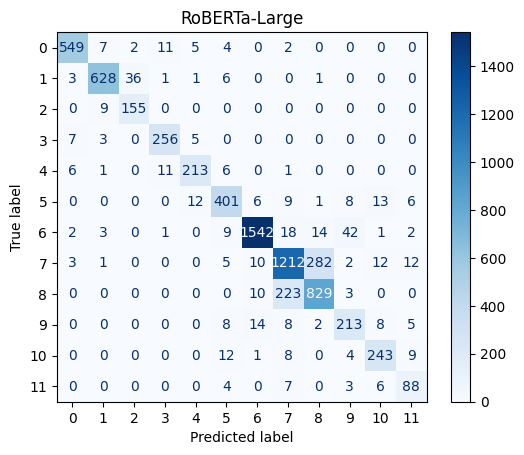

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_conf_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(title)
    plt.grid(False)
    plt.show()

# For traditional ML models
plot_conf_matrix(y_test, lr.predict(X_test), "Logistic Regression")
plot_conf_matrix(y_test, svm.predict(X_test), "SVM")
plot_conf_matrix(y_test, xgb_model.predict(X_test), "XGBoost")
plot_conf_matrix(y_test, lgb_model.predict(X_test), "LightGBM")

# For DL/Transformer models
plot_conf_matrix(y_test, y_pred_bert, "BERT")
plot_conf_matrix(y_test, y_pred_roberta, "RoBERTa")
plot_conf_matrix(y_test, y_pred_distil, "DistilBERT")
plot_conf_matrix(y_test, y_pred_deberta, "DeBERTa")
plot_conf_matrix(y_test, y_pred_roberta_large, "RoBERTa-Large")

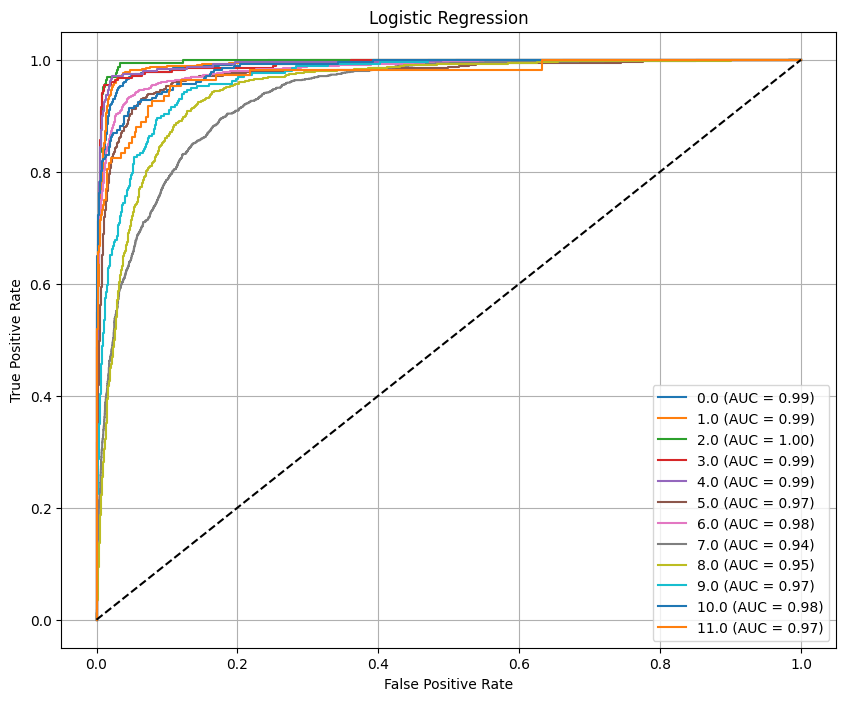

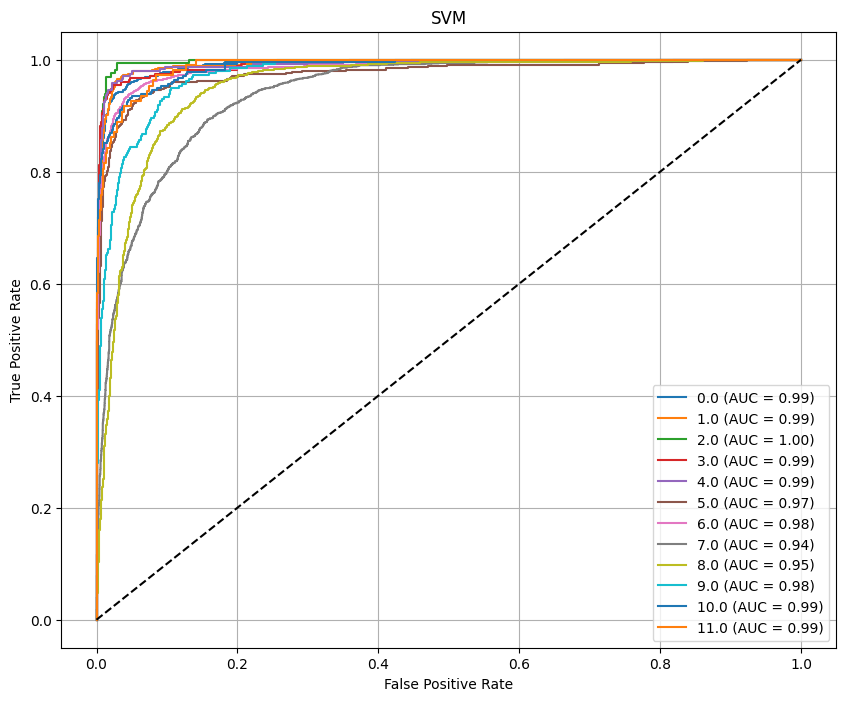

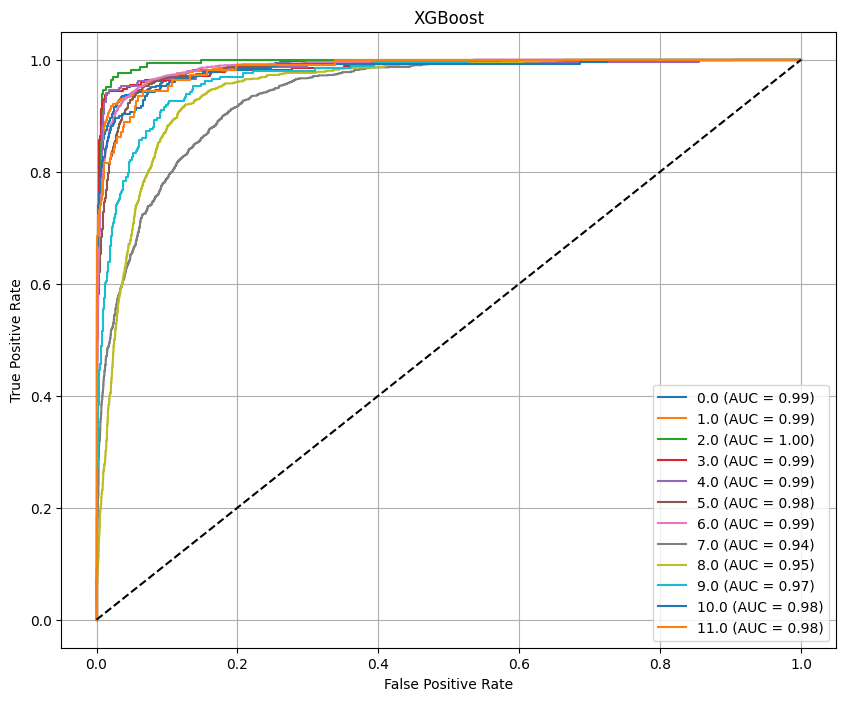

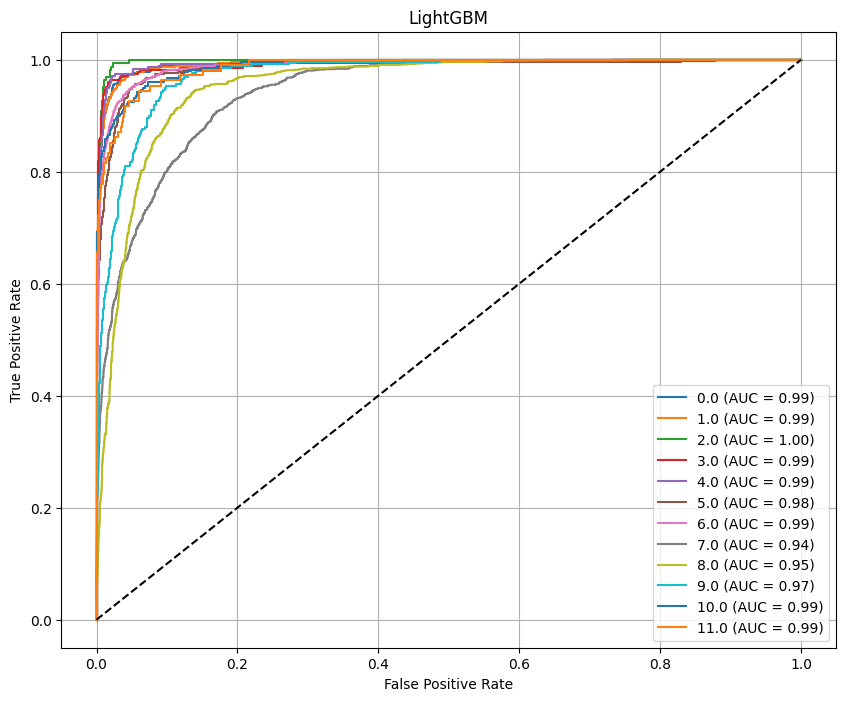

In [21]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def plot_multiclass_roc(model, X_test, y_test, class_names, title='ROC Curve'):
    y_score = model.predict_proba(X_test)
    y_test_bin = label_binarize(y_test, classes=list(range(len(class_names))))

    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{title}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Get label names from encoder
class_names = le.classes_

# Plot ROC for traditional models
plot_multiclass_roc(lr, X_test, y_test, class_names, "Logistic Regression")
plot_multiclass_roc(svm, X_test, y_test, class_names, "SVM")
plot_multiclass_roc(xgb_model, X_test, y_test, class_names, "XGBoost")
plot_multiclass_roc(lgb_model, X_test, y_test, class_names, "LightGBM")

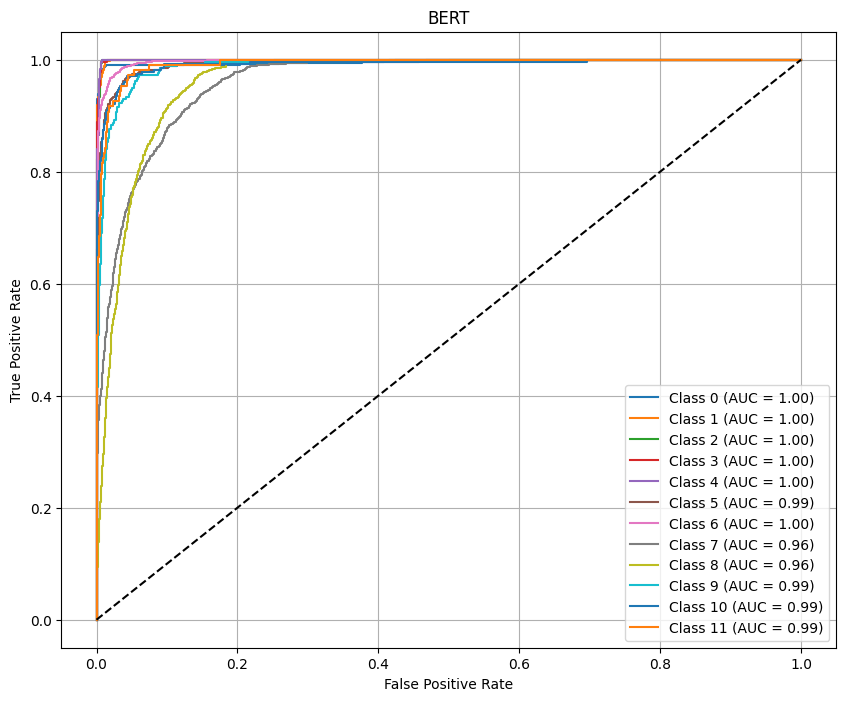

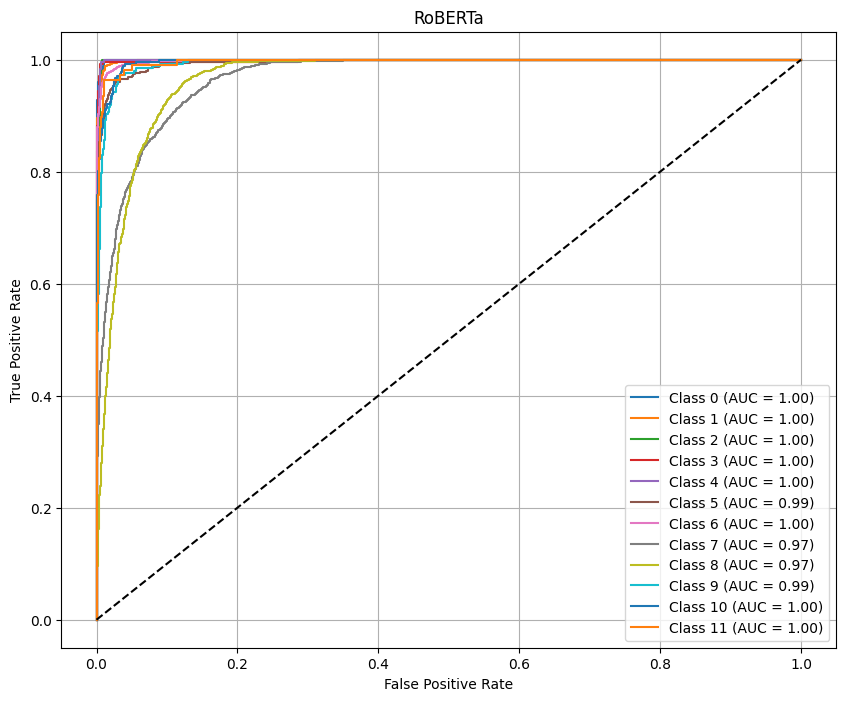

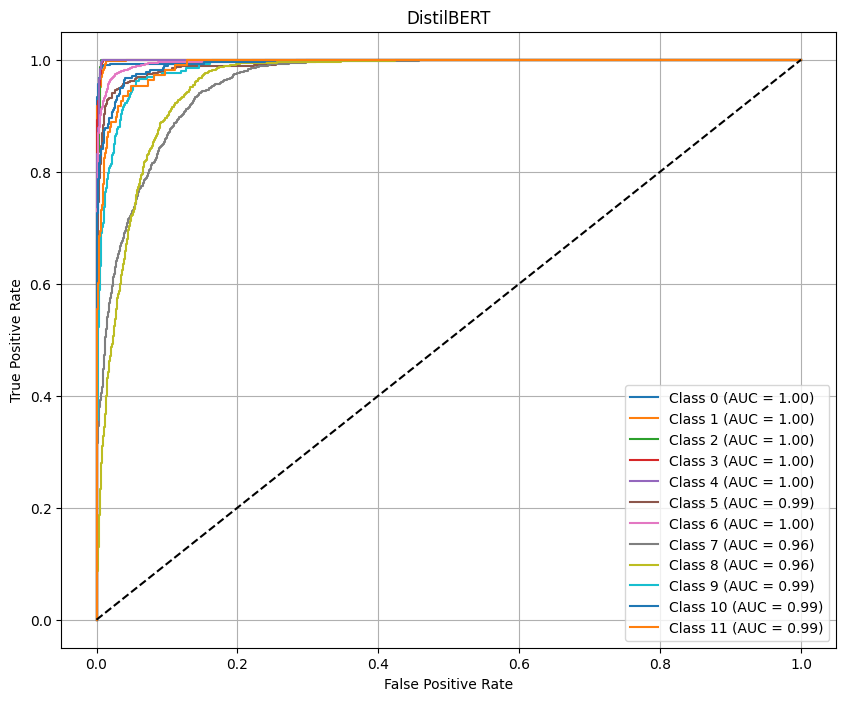

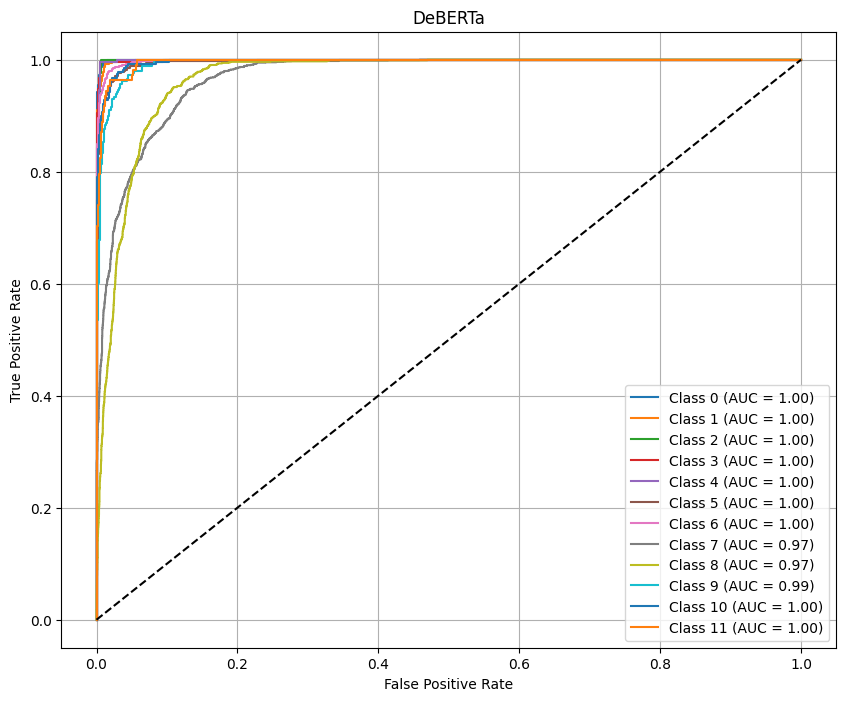

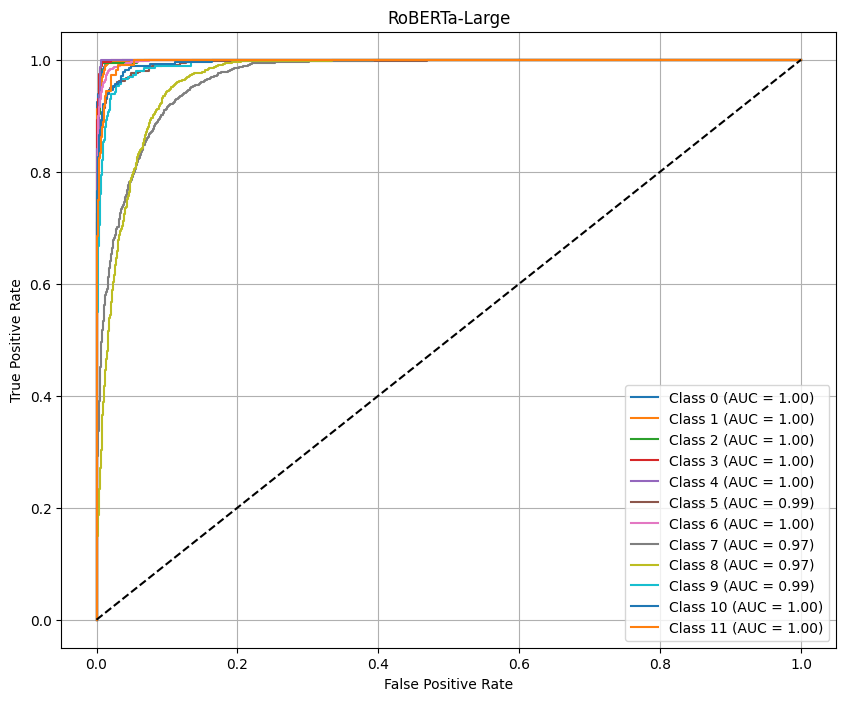

In [22]:
def plot_multiclass_roc_from_logits(logits, y_true, title='Transformer ROC Curve'):
    y_true_bin = label_binarize(y_true, classes=list(range(logits.shape[1])))
    y_probs = tf.nn.softmax(logits, axis=1).numpy()

    plt.figure(figsize=(10, 8))
    for i in range(y_probs.shape[1]):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Plot ROC for each transformer
plot_multiclass_roc_from_logits(preds, y_test, "BERT")
plot_multiclass_roc_from_logits(roberta_preds, y_test, "RoBERTa")
plot_multiclass_roc_from_logits(distil_preds, y_test, "DistilBERT")
plot_multiclass_roc_from_logits(deberta_preds, y_test, "DeBERTa")
plot_multiclass_roc_from_logits(roberta_large_preds, y_test, "RoBERTa-Large")

228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


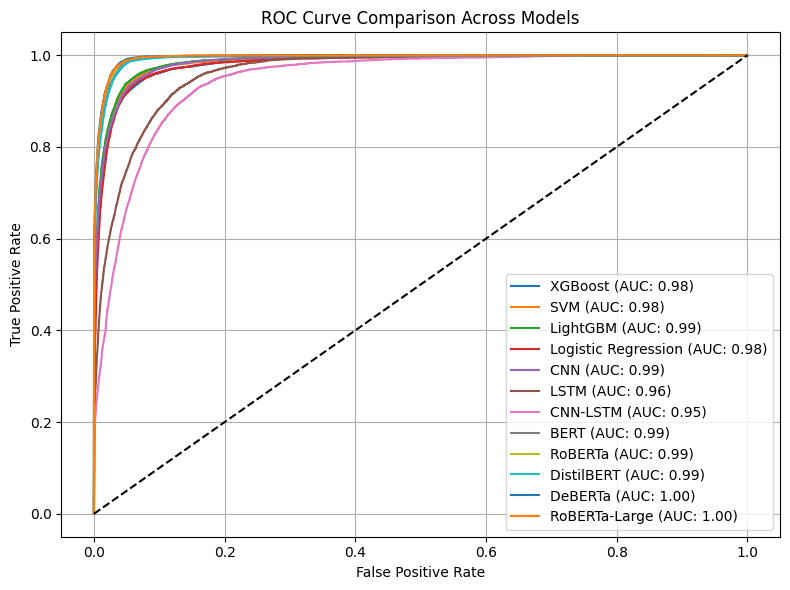

In [23]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))

# For traditional models
def plot_model_roc(model, X_test, y_test, name):
    y_test_bin = label_binarize(y_test, classes=list(range(num_classes)))
    y_score = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC: {roc_auc:.2f})")

plot_model_roc(xgb_model, X_test, y_test, "XGBoost")
plot_model_roc(svm, X_test, y_test, "SVM")
plot_model_roc(lgb_model, X_test, y_test, "LightGBM")
plot_model_roc(lr, X_test, y_test, "Logistic Regression")

# For CNN
y_pred_cnn = cnn.predict(X_test_pad)
fpr, tpr, _ = roc_curve(y_test_dl.ravel(), y_pred_cnn.ravel())
plt.plot(fpr, tpr, label=f"CNN (AUC: {auc(fpr, tpr):.2f})")

# For LSTM
y_pred_lstm = lstm.predict(X_test_pad)
fpr, tpr, _ = roc_curve(y_test_dl.ravel(), y_pred_lstm.ravel())
plt.plot(fpr, tpr, label=f"LSTM (AUC: {auc(fpr, tpr):.2f})")

# For CNN-LSTM
y_pred_cnn_lstm = cnn_lstm.predict(X_test_pad)
fpr, tpr, _ = roc_curve(y_test_dl.ravel(), y_pred_cnn_lstm.ravel())
plt.plot(fpr, tpr, label=f"CNN-LSTM (AUC: {auc(fpr, tpr):.2f})")

# For transformers
def plot_roc_from_logits(logits, y_true, name):
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    y_probs = tf.nn.softmax(logits, axis=1).numpy()
    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_probs.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC: {roc_auc:.2f})")

plot_roc_from_logits(preds, y_test, "BERT")
plot_roc_from_logits(roberta_preds, y_test, "RoBERTa")
plot_roc_from_logits(distil_preds, y_test, "DistilBERT")
plot_roc_from_logits(deberta_preds, y_test, "DeBERTa")
plot_roc_from_logits(roberta_large_preds, y_test, "RoBERTa-Large")

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.title("ROC Curve Comparison Across Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()